## Setting up dataset
In this notebook first I will setup our dataset. This includes data reading and preprocessing, and then after that I will save the pre-processed dataset for training and testing purpose.

### Import files
First I will import the files which are required. I will use `librosa` library for reading the audio files and then converting them into `stt spectograms`, `scipy` library is used to convert the audio files into `FFT` singals. And other libraries like numpy and train_test_split are used for other purposes.

In [1]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from scipy.fft import fft
from librosa import display
import pandas as pd
import numpy as np
import pickle
import librosa
import os
import warnings

warnings.filterwarnings('ignore')

## Spliting the song
This is the help function which will help in spliting the songs into 3 second clips. I will use the **window size of 0.10** which will ensure that the clips will be of 3 seconds. And I will use **50% overlap to reduce the chances of overfitting**.

In [2]:
def splitsongs(X, y, window = 0.05, overlap = 0.5):
    # Empty lists to hold our results
    temp_X = []
    temp_y = []

    # Get the input song array size
    xshape = X.shape[0]
    chunk = int(xshape * window)
    offset = int(chunk * (1 - overlap))
    
    # Split the song and create new ones on windows
    spsong = [X[i:i+chunk] for i in range(0, xshape, offset)]
    for s in spsong:
        if s.shape[0] != chunk:
            continue

        temp_X.append(s)
        temp_y.append(y)

    return np.array(temp_X), np.array(temp_y)

## Reading Data
This function will be used to read the audio files from directiory, and then after reading each file it will use the **splitsong** function to split up the songs into 3 seconds clip and save them in a numpy array.

In [3]:
samp_rate = 0
def read_data(path):
    path = "./Data/genres_original/"
    genres = os.listdir(path)
    genres_labels = {}
    for index, genre in enumerate(genres):
        genres_labels[genre] = index
    
    features = []
    labels = []
    
    for genre in genres:
        print("Started {} Genre audio file reading!".format(genre))
        audio_files = os.listdir(path+genre)
        for audio_file in audio_files:
            audio_file_path = path + genre + "/" + audio_file
            try:
                audio_time_series, sampling_rate = librosa.load(audio_file_path)
                samp_rate = sampling_rate
                X, y = splitsongs(audio_time_series, genres_labels[genre], window=0.10)
                features.extend(X)
                labels.extend(y)

            except Exception:
                print("{} is an empty file!".format(audio_file_path))

        print("{} Genre audio file reading completed!".format(genre))
    
    return np.array(features), np.array(labels)

## Conversion to STFT
This function will help to convert each 3 second clip into the STFT form. First with the help of `scipy library` fft function I will convert the audio into FFT form of length **32700** then after that I will use `librosa library` stft function to convert the fft result into stft form, I will use the length of 1024. In the end this will return the array of shape (128, 5113)

In [4]:
def convert_audio_to_stft(features):
    
    converted_files = []
    for feature in features:
        fft_result1 = np.abs(fft(feature, 32700))
        stft_trans2 = np.abs(librosa.stft(fft_result1, 1024))
        converted_files.append(stft_trans2.reshape(128, 513))
    
    return np.array(converted_files)


Now here I'm calling the read function to read and split the songs

In [5]:
path = "./Data/genres_original/"
features, labels = read_data(path)

Started disco Genre audio file reading!
disco Genre audio file reading completed!
Started reggae Genre audio file reading!
reggae Genre audio file reading completed!
Started pop Genre audio file reading!
pop Genre audio file reading completed!
Started metal Genre audio file reading!
metal Genre audio file reading completed!
Started jazz Genre audio file reading!
./Data/genres_original/jazz/jazz.00054.wav is an empty file!
jazz Genre audio file reading completed!
Started hiphop Genre audio file reading!
hiphop Genre audio file reading completed!
Started country Genre audio file reading!
country Genre audio file reading completed!
Started rock Genre audio file reading!
rock Genre audio file reading completed!
Started classical Genre audio file reading!
classical Genre audio file reading completed!
Started blues Genre audio file reading!
blues Genre audio file reading completed!


### Audio Signal representation
This graph is called time-domain representation of a given signal. This shows us the loudness(amplitude) of the sound wave changing with time.

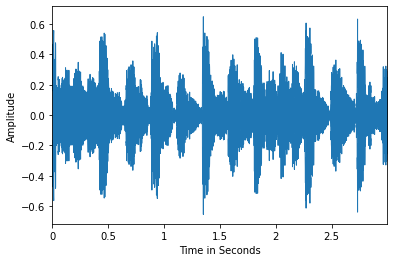

In [6]:
plt.figure()
display.waveplot(y = features[0], sr =  22050)
plt.xlabel("Time in Seconds")
plt.ylabel("Amplitude")
plt.show()

### Train Test Split
Now here I will split the dataset into training, testing and validation sets, I have choosen **80% training**. **10% testing** and **10%validation sets**.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

## STFT Transformation
Now after splitting the data into training, testing and validation sets, I will convert them into stft form.

In [11]:
X_train = convert_audio_to_stft(X_train)
X_val = convert_audio_to_stft(X_val)
X_test = convert_audio_to_stft(X_test)

### STFT Visualization
The spectrogram is a plot of signal amplitude versus time and frequency. In our visualization we can see **HZ (frequency)**, **Time** and **db (amplitude)** of a signal.

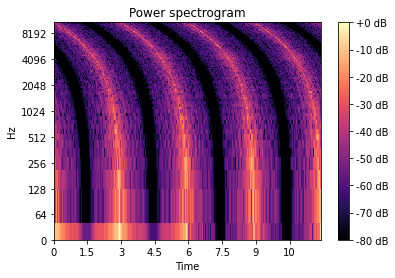

In [12]:
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(X_train[0],
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

Reshaping the dataset so it can be used as input in our RCNN model

In [13]:
X_train = X_train.reshape(-1, 128, 513, 1)
X_val = X_val.reshape(-1, 128, 513, 1)
X_test = X_test.reshape(-1, 128, 513, 1)

One-Hot Encoding the labels so we can use them in our RCNN model.

In [14]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

## Saving dataset
Now after preproceesing of data I will save them so I can use them later for training and testing purpose.

In [15]:
with open('processed_data/X_train.pickle', 'wb') as f:
    pickle.dump(X_train, f)
    
with open('processed_data/X_valid.pickle', 'wb') as f:
    pickle.dump(X_val, f)
    
with open('processed_data/X_test.pickle', 'wb') as f:
    pickle.dump(X_test, f)

In [16]:
with open('processed_data/y_train.pickle', 'wb') as f:
    pickle.dump(y_train, f)
    
with open('processed_data/y_valid.pickle', 'wb') as f:
    pickle.dump(y_val, f)
    
with open('processed_data/y_test.pickle', 'wb') as f:
    pickle.dump(y_test, f)